In [1]:
import json
import csv
from datasets import load_dataset
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # required for 3D

In [2]:
from utils_toxic import *
from sklearn.svm import SVC

In [ ]:
with open(f'./features/llama_7B_toxigen_vicuna_texts.json', 'r') as json_file:
    data = json_file.readlines()

In [11]:
# Save to CSV
with open('./TruthfulQA/llama_7B_toxigen_vicuna.csv', 'w', newline='', encoding='utf-8') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=["text", "toxic_text", "non_toxic_text"])
    writer.writeheader()
    for line in data:
        row = json.loads(line.strip())
        writer.writerow(row)

In [12]:
with open(f'./features/llama_7B_hate_vicuna_texts.json', 'r') as json_file:
    data = json_file.readlines()


# Save to CSV
with open('./TruthfulQA/llama_7B_hate_vicuna.csv', 'w', newline='', encoding='utf-8') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=["text", "toxic_text", "non_toxic_text"])
    writer.writeheader()
    for line in data:
        row = json.loads(line.strip())
        writer.writerow(row)

In [18]:
with open(f'./features/llama_7B_toxigen_vicuna_texts.json', 'r') as json_file:
    data = json_file.readlines()

=========================================

In [23]:
def get_activations(labels, head_wise_activations, dataset, model_name): 
    sentences = pd.read_csv(f'./TruthfulQA/{dataset}.csv')
    texts = sentences["text"]
    toxic_texts = sentences["toxic_text"]
    non_toxic_texts = sentences["non_toxic_text"]
    
    print("SHAPES", len(labels), len(head_wise_activations), len(texts))
    
    grouped_activations = []
    grouped_labels = []
    idxs_to_split_at = []
    used_idxs = set()
    
    for i in range(0, len(labels), 2):
        group_acts = [head_wise_activations[i], head_wise_activations[i+1]]
        group_labels = [labels[i], labels[i+1]]

        if sorted(group_labels) != [0, 1]:
            print(f"[Warning] Pair at index {i} doesn't contain both toxic and non-toxic: {group_labels}")
            continue
            

        grouped_activations.append(np.stack(group_acts))  # (2, L, H, D)
        grouped_labels.append(group_labels)
        idxs_to_split_at.append(len(grouped_activations) * 2)  # running total


    return grouped_activations, grouped_labels, idxs_to_split_at

In [24]:
num_heads = 32
npy_path = f'/work/hdd/bdeb/chenyuen0103/toxic/features'
# act =  np.load(f'{npy_path}/llama_7B_toxigen_vicuna_head_wise.npy')
# head_wise_activations = rearrange(act, 'b l (h d) -> b l h d', h = num_heads)
# top_heads = np.load(f'{npy_path}/llama_7B_toxigen_vicuna_top_heads.npy')
# labels =  np.load(f'{npy_path}/llama_7B_toxigen_vicuna_labels.npy')

In [25]:
len(labels)

13132

In [26]:
dataset_name = 'toxigen_vicuna'
model_name = 'llama_7B'
separated_head_wise_activations, separated_labels, idxs_to_split_at = get_activations(labels, head_wise_activations, dataset_name, model_name)

SHAPES 13132 13132 6566


In [27]:
# all_activations = np.concatenate(separated_head_wise_activations, axis=0)
selected = []
for sample in tqdm(head_wise_activations[:10000]):  # sample: [32, 32, 128]
    head_vectors = []
    for layer, head in top_heads:
        vec = sample[layer, head, :]  # shape [128]
        head_vectors.append(vec)
    head_vectors = np.stack(head_vectors)  # shape: [num_top_heads, 128]
    selected.append(head_vectors)

# Final output
selected = np.stack(selected)  # shape: [n, num_top_heads, 128]


100%|██████████| 10000/10000 [00:03<00:00, 2713.73it/s]


In [28]:
flat_selected = act[:10000].reshape(selected.shape[0], -1)  
pca = PCA(n_components=3)  # or 3 for 3D
X_reduced = pca.fit_transform(flat_selected)



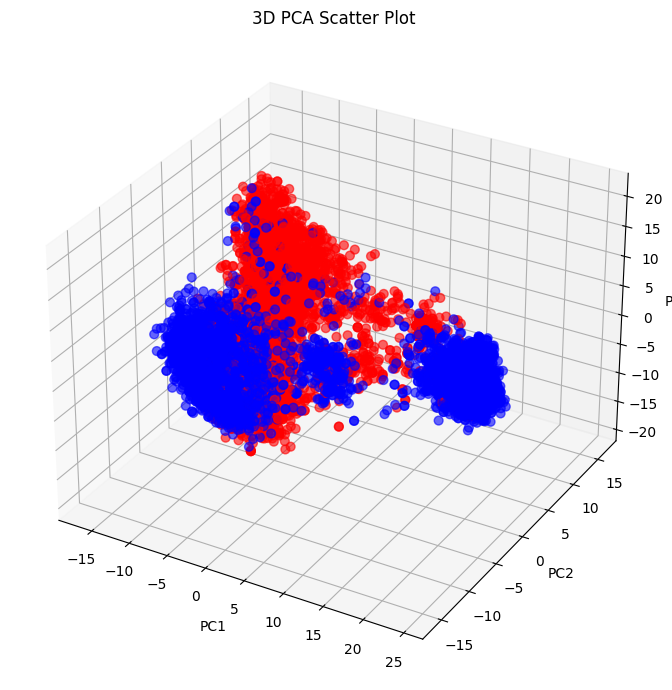

In [9]:
# Create 3D plot
colors = ['red' if label == 1 else 'blue' for label in labels[:10000]]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=colors, s=40, alpha=0.6)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Scatter Plot')
plt.tight_layout()
plt.show()

In [10]:
clf = SVC(kernel='linear', class_weight='balanced')  #SVC(C=3, gamma='auto', kernel='rbf')
clf.fit(flat_selected[:8000], labels[:8000])
(clf.predict(flat_selected[8000:]) == labels[8000:]).mean()

: 

In [12]:
grouped_activations, grouped_labels, idxs_to_split_at = get_activations(labels, act, 'toxigen_vicuna', 'llama_7B')

SHAPES 13132 13132 6566


In [ ]:
diffs = act[1::2] - act[0::2]
flat_diffs = diffs.reshape(diffs.shape[0], -1)  
flat_act = act.reshape(act.shape[0], -1)  
pca = PCA(n_components=3)  # or 3 for 3D
X_reduced = pca.fit_transform(flat_act)

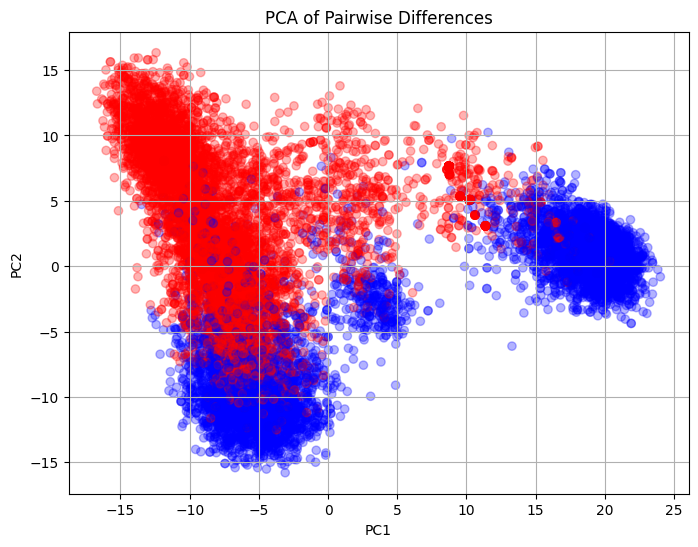

In [22]:
# Optional: color by labels
colors = ['red' if label == 1 else 'blue' for label in labels]

plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=colors, alpha=0.3)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Pairwise Differences")
plt.grid(True)
plt.show()


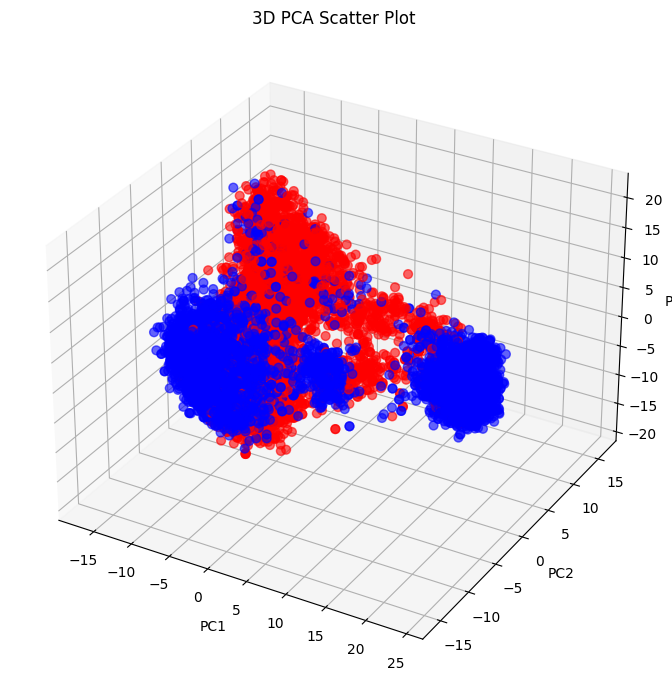

In [24]:
# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=colors, s=40, alpha=0.6)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Scatter Plot')
plt.tight_layout()
plt.show()

In [27]:
clf = SVC(kernel='linear', class_weight='balanced')  #SVC(C=3, gamma='auto', kernel='rbf')
clf.fit(X_reduced[:10000], labels[:10000])
(clf.predict(X_reduced[10000:]) == labels[10000:]).mean()

SVC(class_weight='balanced', kernel='linear')

0.9109195402298851

: 